In [ ]:
!pip install tmu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.6/439.6 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 4.2 MB/s eta 0:00:00


In [ ]:
import pickle
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tmu.models.classification.vanilla_classifier import TMClassifier

# VGG-19 All Blocks + Tsetlin Machine for CIFAR-10 Dataset

This notebook implements the complete VGG-19 architecture (all five blocks) followed by Tsetlin Machine to classify the CIFAR-10 dataset.

In [ ]:
from tensorflow.keras.datasets import cifar10

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
import numpy as np

In [ ]:
# Load CIFAR-10 dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Split training data to create validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Reshape labels to 1D arrays
y_train = y_train[:,0]
y_val = y_val[:,0]
y_test = y_test[:,0]

print("Load Data Successfully")

print("\nDataset Shapes:")
print(f"Train: features {np.array(X_train).shape}, labels {np.array(y_train).shape}")
print(f"Val: features {np.array(X_val).shape}, labels {np.array(y_val).shape}")
print(f"Test: features {np.array(X_test).shape}, labels {np.array(y_test).shape}")

Load Data Successfully

Dataset Shapes:
Train: features (40000, 32, 32, 3), labels (40000,)
Val: features (10000, 32, 32, 3), labels (10000,)
Test: features (10000, 32, 32, 3), labels (10000,)


In [ ]:
import matplotlib.pyplot as plt

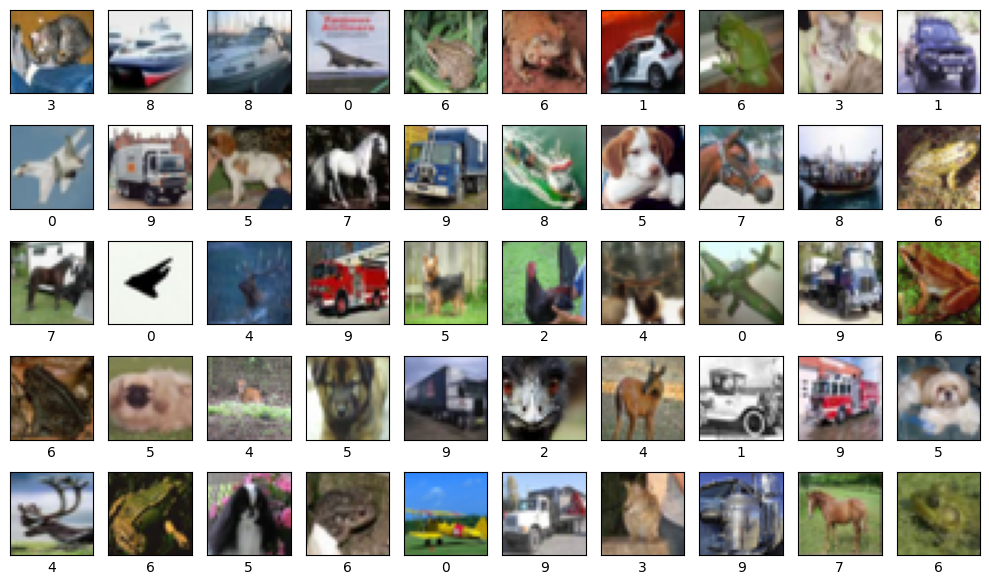

In [ ]:
# Visualize some images from the dataset
plt.figure(figsize=(10,6))
for i in range(0,50):
    plt.subplot(5,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_test[i])
    plt.xlabel(y_test[i])
plt.tight_layout()

In [ ]:
# CIFAR-10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Create a mapping from class index to class name
class_mapping = {i: name for i, name in enumerate(class_names)}
print(class_mapping)

{0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}


In [ ]:
# Normalize images for CNN (pixel values from [0, 255] to [0, 1])
X_train_norm = X_train / 255.0
X_val_norm = X_val / 255.0
X_test_norm = X_test / 255.0

print(f"Input shape: {X_train_norm.shape[1:]}")
print(f"Data type: {X_train_norm.dtype}")
print(f"Value range: [{X_train_norm.min()}, {X_train_norm.max()}]")

Input shape: (32, 32, 3)
Data type: float64
Value range: [0.0, 1.0]


In [ ]:
from tensorflow.keras.layers import Input

In [ ]:
from tensorflow.keras.layers import Conv2D

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D  # Import MaxPooling2D

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten # Import Flatten

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense # Import Dense

In [ ]:
from tensorflow.keras.models import Model

In [ ]:
from tensorflow.keras.optimizers import Adam

In [ ]:
# Define VGG-19 architecture with all blocks for CIFAR-10
def build_vgg19_full_model(input_shape=(32, 32, 3)):
    input_layer = Input(shape=input_shape)

    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(input_layer)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv4')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv4')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv4')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

    # Flatten layer
    x = Flatten(name='flatten')(x)

    # Feature layer (for Tsetlin Machine)
    feature_layer = Dense(4096, activation='sigmoid', name='feature_layer')(x)

    # Output layer
    output_layer = Dense(10, activation='softmax', name='predictions')(feature_layer)

    # Create model
    model = Model(inputs=input_layer, outputs=output_layer, name='vgg19_full')
    feature_extractor = Model(inputs=input_layer, outputs=feature_layer, name='feature_extractor')

    return model, feature_extractor

# Build the model
vgg19_full_model, feature_extractor = build_vgg19_full_model(input_shape=(32, 32, 3))

# Compile the model
vgg19_full_model.compile(optimizer=Adam(learning_rate=0.001),
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy'])

# Print model summary
vgg19_full_model.summary()

Model: "vgg19_full"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 4, 4, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 22,166,602 (84.56 MB)

 Trainable params: 22,166,602 (84.56 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
# Define callbacks for training
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
checkpoint = ModelCheckpoint('vgg19_full_cifar10_best.h5', monitor='val_accuracy', save_best_only=True, mode='max')

# Train the model
print("\nTraining complete VGG-19 model...")
batch_size = 32
epochs = 100

history = vgg19_full_model.fit(
    X_train_norm, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val_norm, y_val),
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)


Training complete VGG-19 model...
Epoch 1/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.0976 - loss: 2.5353

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 88s 60ms/step - accuracy: 0.0976 - loss: 2.5353 - val_accuracy: 0.1030 - val_loss: 2.5548 - learning_rate: 0.0010
Epoch 2/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 130s 57ms/step - accuracy: 0.1019 - loss: 2.4868 - val_accuracy: 0.0973 - val_loss: 2.4145 - learning_rate: 0.0010
Epoch 3/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.0982 - loss: 2.4939

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 80s 64ms/step - accuracy: 0.0982 - loss: 2.4939 - val_accuracy: 0.1040 - val_loss: 2.3372 - learning_rate: 0.0010
Epoch 4/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 76s 59ms/step - accuracy: 0.0999 - loss: 2.4748 - val_accuracy: 0.1015 - val_loss: 2.4305 - learning_rate: 0.0010
Epoch 5/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 73s 58ms/step - accuracy: 0.0996 - loss: 2.4772 - val_accuracy: 0.1030 - val_loss: 2.6041 - learning_rate: 0.0010
Epoch 6/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 82s 58ms/step - accuracy: 0.0980 - loss: 2.4954 - val_accuracy: 0.0996 - val_loss: 2.4291 - learning_rate: 0.0010
Epoch 7/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 82s 58ms/step - accuracy: 0.0997 - loss: 2.4727 - val_accuracy: 0.1040 - val_loss: 2.4604 - learning_rate: 0.0010
Epoch 8/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 84s 59ms/step - accuracy: 0.0999 - loss: 2.4498 - val_accuracy: 0.0996 - val_loss: 2.6344 - learning_rate: 0.0010
Epoch 9/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 82s 59ms/step - accuracy: 0

In [ ]:
# Evaluate the model on training, validation, and test sets
train_scores = vgg19_full_model.evaluate(X_train_norm, y_train, verbose=0)
val_scores = vgg19_full_model.evaluate(X_val_norm, y_val, verbose=0)
test_scores = vgg19_full_model.evaluate(X_test_norm, y_test, verbose=0)

print("\nModel Evaluation:")
print(f"Train Loss: {train_scores[0]:.4f}, Train Accuracy: {train_scores[1]*100:.2f}%")
print(f"Validation Loss: {val_scores[0]:.4f}, Validation Accuracy: {val_scores[1]*100:.2f}%")
print(f"Test Loss: {test_scores[0]:.4f}, Test Accuracy: {test_scores[1]*100:.2f}%")


Model Evaluation:
Train Loss: 2.3027, Train Accuracy: 9.93%
Validation Loss: 2.3026, Validation Accuracy: 10.30%
Test Loss: 2.3027, Test Accuracy: 10.00%


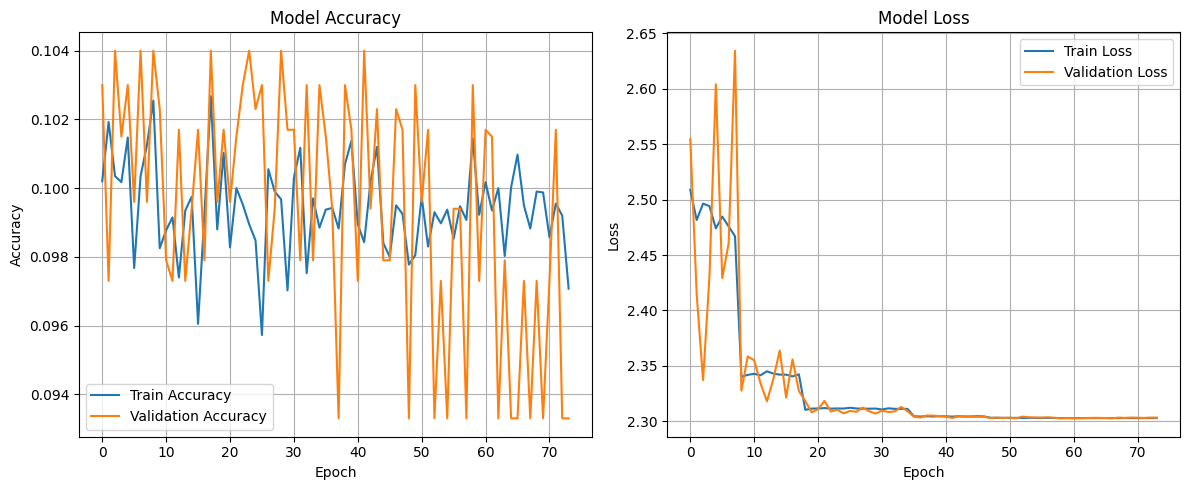

In [ ]:
# Plot training history
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Extract features using the feature extractor model
X_train_features = feature_extractor.predict(X_train_norm)
X_val_features = feature_extractor.predict(X_val_norm)
X_test_features = feature_extractor.predict(X_test_norm)

print(f"Feature shapes:")
print(f"Training features: {X_train_features.shape}")
print(f"Validation features: {X_val_features.shape}")
print(f"Test features: {X_test_features.shape}")

# Binarize the features (threshold at 0.5 for sigmoid activation)
X_train_bin = (X_train_features > 0.5).astype(np.uint32)
X_val_bin = (X_val_features > 0.5).astype(np.uint32)
X_test_bin = (X_test_features > 0.5).astype(np.uint32)

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
Feature shapes:
Training features: (40000, 4096)
Validation features: (10000, 4096)
Test features: (10000, 4096)


In [ ]:
!pip install tmu

In [ ]:
from tmu.models.classification.vanilla_classifier import TMClassifier

ERROR:tmu.clause_bank.clause_bank_cuda:No module named 'pycuda'
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/tmu/clause_bank/clause_bank_cuda.py", line 41, in <module>
    from pycuda._driver import Device, Context
ModuleNotFoundError: No module named 'pycuda'


In [ ]:
from sklearn.metrics import accuracy_score  # Import accuracy_score

# Initialize Tsetlin Machine with the specified parameters
print("\nInitializing Tsetlin Machine...")
tm = TMClassifier(
    number_of_clauses=1000, # C
    T=22,                   # T parameter
    s=16.0,                 # s parameter
    patch_dim=None,         # Set to None for tabular data
    boost_true_positive_feedback=1,
    # number_of_state_bits=8,  # Remove this line
    max_included_literals=X_train_bin.shape[1] # All features can be included
)


# Convert y_train to uint32
y_train = y_train.astype(np.uint32)

# Train Tsetlin Machine
print("\nTraining Tsetlin Machine on CNN-extracted features...")
tm.fit(X_train_bin, y_train, epochs=100, incremental=True)

# Evaluate on validation and test sets
y_pred_val = tm.predict(X_val_bin)  # Get predicted labels for validation set
val_acc = 100 * accuracy_score(y_val, y_pred_val)  # Calculate validation accuracy

y_pred_test = tm.predict(X_test_bin)  # Get predicted labels for test set
test_acc = 100 * accuracy_score(y_test, y_pred_test)  # Calculate test accuracy

print(f"Tsetlin Machine Validation Accuracy: {val_acc:.2f}%")
print(f"Tsetlin Machine Test Accuracy: {test_acc:.2f}%")


Initializing Tsetlin Machine...

Training Tsetlin Machine on CNN-extracted features...
Tsetlin Machine Validation Accuracy: 9.73%
Tsetlin Machine Test Accuracy: 10.00%


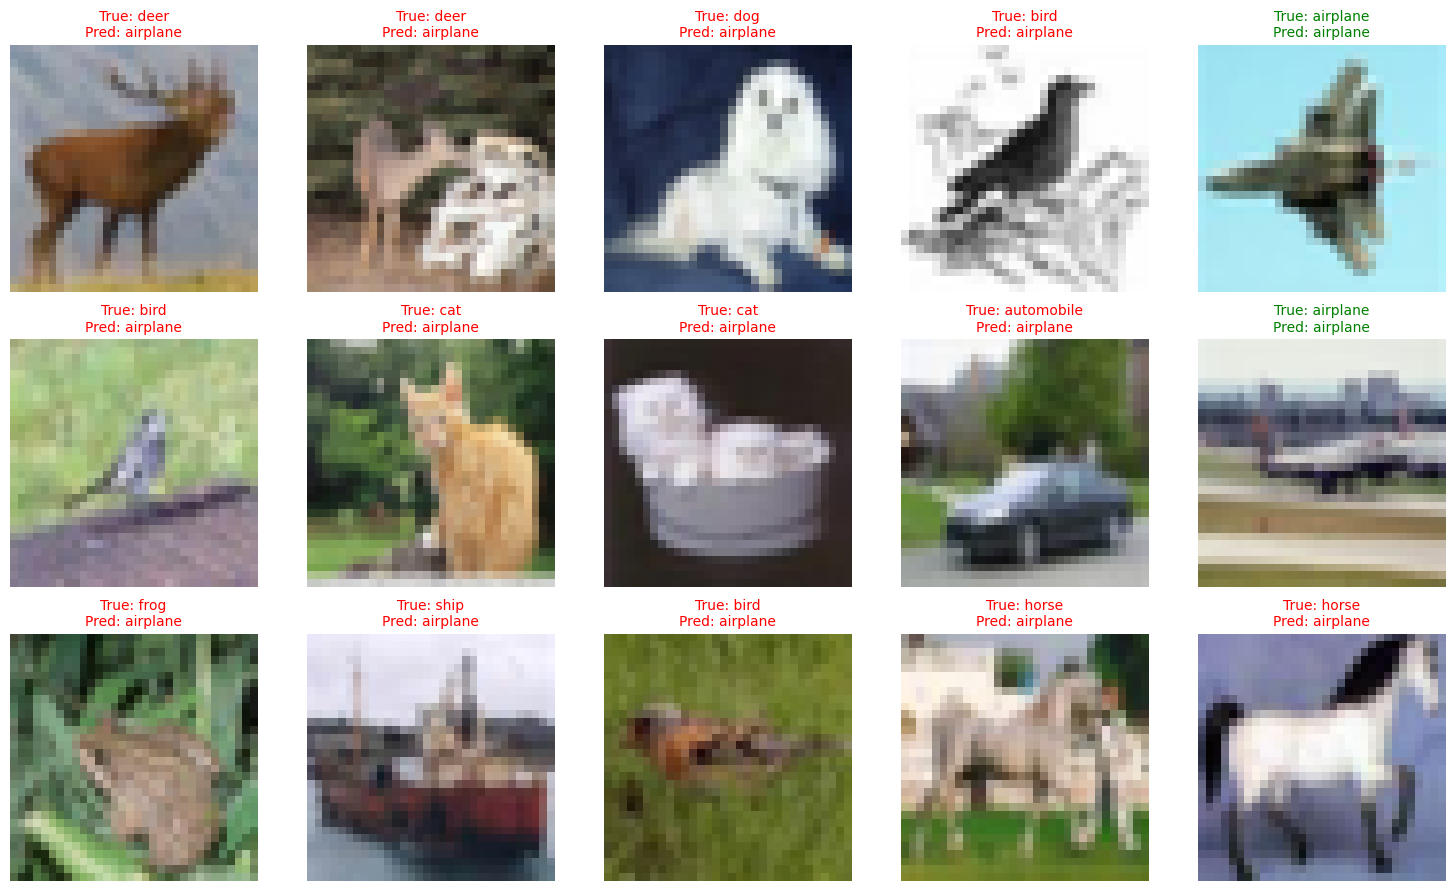

In [ ]:
# Make predictions with Tsetlin Machine
y_pred_tm = tm.predict(X_test_bin)

# Select 15 random test samples
num_samples_to_show = 15
indices = np.random.choice(len(X_test), size=num_samples_to_show, replace=False)

# Create a figure with 3 rows and 5 columns
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 9))
axes = axes.flatten()  # Flatten for easy iteration

for ax, idx in zip(axes, indices):
    img = X_test[idx]         # Original image for display
    true_label = y_test[idx]
    pred_label = y_pred_tm[idx]

    # Retrieve the actual class names
    true_class_name = class_mapping.get(true_label, 'Unknown')
    pred_class_name = class_mapping.get(pred_label, 'Unknown')

    # Display the image
    ax.imshow(img)

    # Set title color based on prediction correctness
    title_color = 'green' if true_label == pred_label else 'red'

    ax.set_title(f"True: {true_class_name}\nPred: {pred_class_name}",
                 fontsize=10, color=title_color)
    ax.axis('off')

plt.tight_layout()
plt.show()

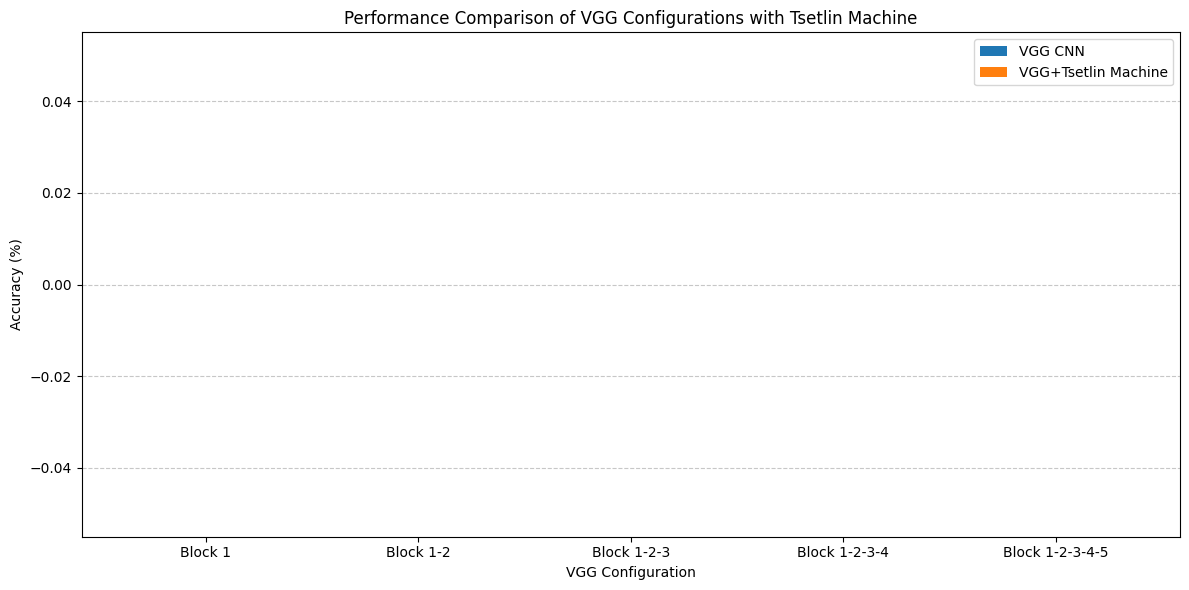

In [ ]:
# Compare performance across different VGG configurations with Tsetlin Machine
import matplotlib.pyplot as plt

# These values would be collected after running all notebooks
# Placeholder values - replace with actual results after experiments
configurations = ['Block 1', 'Block 1-2', 'Block 1-2-3', 'Block 1-2-3-4', 'Block 1-2-3-4-5']
vgg_accuracies = [0, 0, 0, 0, 0]  # Replace with actual VGG CNN accuracies
tm_accuracies = [0, 0, 0, 0, 0]   # Replace with actual Tsetlin Machine accuracies

# Plot comparison
plt.figure(figsize=(12, 6))
x = np.arange(len(configurations))
width = 0.35

plt.bar(x - width/2, vgg_accuracies, width, label='VGG CNN')
plt.bar(x + width/2, tm_accuracies, width, label='VGG+Tsetlin Machine')

plt.xlabel('VGG Configuration')
plt.ylabel('Accuracy (%)')
plt.title('Performance Comparison of VGG Configurations with Tsetlin Machine')
plt.xticks(x, configurations)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()